# IMDB LSTM

## #01. 패키지 준비하기

In [1]:
import helper
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## #03. 데이터셋 준비

In [2]:
# 가장 빈번하게 사용되는 단어의 개수.
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

17464789/17464789 [==============================] - 0s 0us/step
훈련 데이터 (25000,) 레이블 (25000,)
검증 데이터 (25000,) 레이블 (25000,)


## #04. 데이터 전처리

### 1. 데이터를 동일한 길이로 맞추기 (padding)

In [3]:
# 최대 문장 길이
max_len = 500

print('Before pad_sequences: ', len(x_train[0]), len(x_train[1]))

pad_x_train = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding = 'pre')

#  원래 단어의 앞에 ‘지정해준 단어의 길이 – 원래 단어의 길이’(500 –218)만큼 0이 추가된 것을 볼 수 있다.
print('After pad_sequences: ', len(pad_x_train[0]), len(pad_x_train[1]))

print(pad_x_train[0])

Before pad_sequences:  218 189
After pad_sequences:  500 500
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

## #05. 데이터셋 분할하기

이미 데이터셋이 훈련데이터와 검증데이터로 분리되어 있기 때문에 별도의 분할 작업을 수행할 필요는 없다.

## #06. 모델 개발

### 모델 정의 (LSTM)

In [4]:
model = Sequential()

model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_len))
model.add(LSTM(32, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

# 결국은 긍정, 부정을 분류 하는 문제이므로 이진분류에 해당한다.
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 331473 (1.26 MB)
Trainable params: 331473 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [5]:
result = model.fit(pad_x_train, y_train, epochs=500, validation_data=(pad_x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
782/782 [==============================] - 1870s 2s/step - loss: 0.4090 - acc: 0.8084 - val_loss: 0.3089 - val_acc: 0.8758 - lr: 0.0010
Epoch 2/500
782/782 [==============================] - 1768s 2s/step - loss: 0.2545 - acc: 0.9000 - val_loss: 0.3145 - val_acc: 0.8726 - lr: 0.0010
Epoch 3/500
782/782 [==============================] - 1719s 2s/step - loss: 0.1894 - acc: 0.9300 - val_loss: 0.3482 - val_acc: 0.8672 - lr: 0.0010
Epoch 4/500
782/782 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.9434
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 [==============================] - 1721s 2s/step - loss: 0.1560 - acc: 0.9434 - val_loss: 0.3777 - val_acc: 0.8695 - lr: 0.0010
Epoch 5/500
782/782 [==============================] - 1732s 2s/step - loss: 0.1035 - acc: 0.9642 - val_loss: 0.4026 - val_acc: 0.8719 - lr: 5.0000e-04
Epoch 6/500
782/782 [==============================] - 1727s 2s/step - loss: 0.0795 - acc: 0.9745 - 

## #06. 학습결과 평가

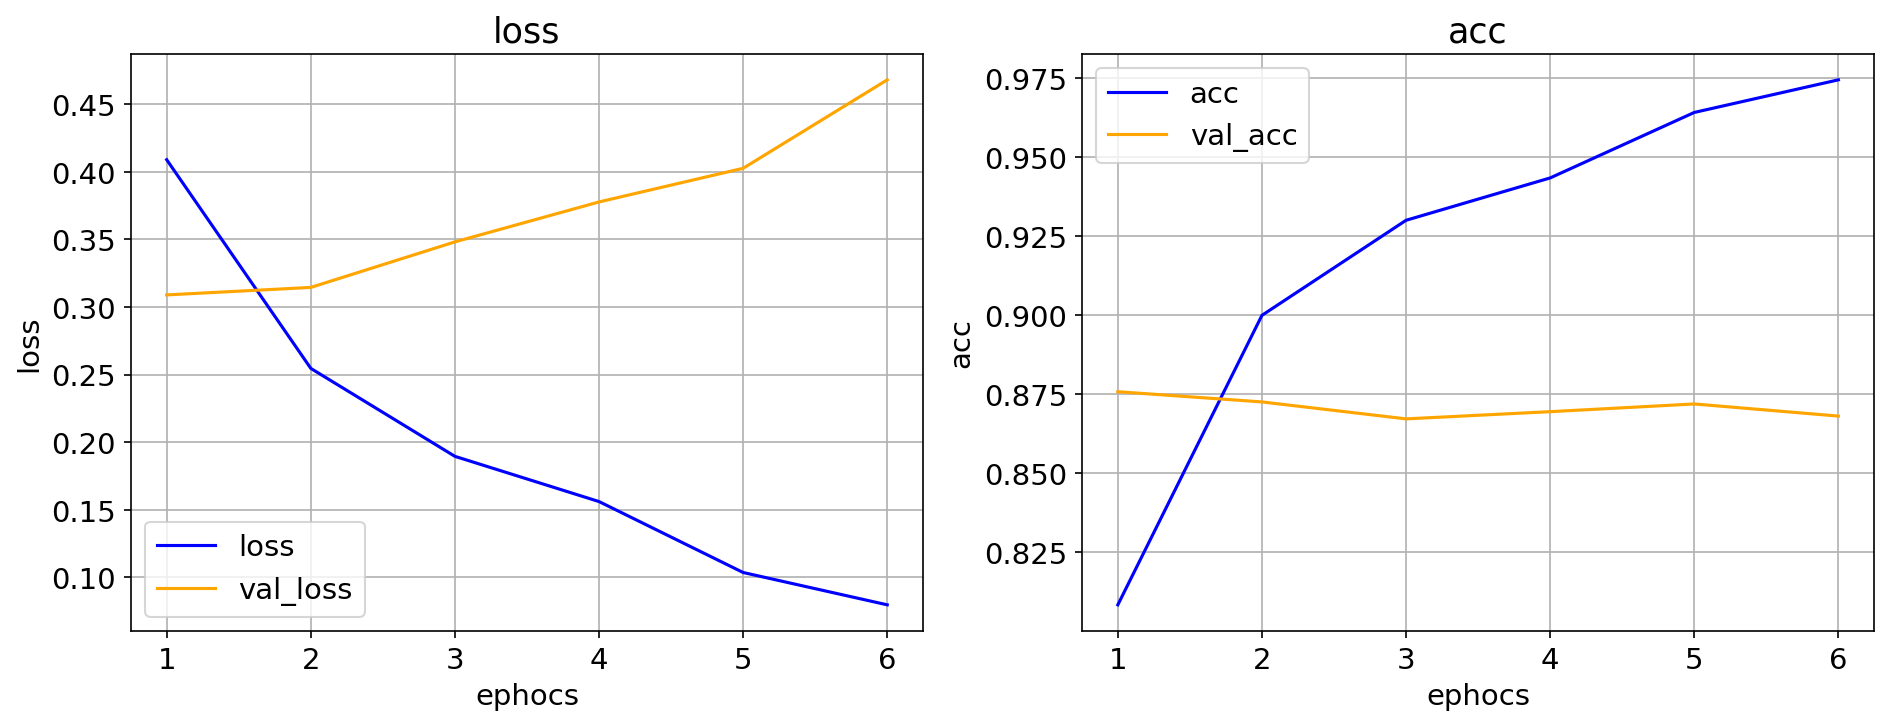

782/782 [==============================] - 111s 141ms/step - loss: 0.0451 - acc: 0.9886
최종 훈련 손실률: 0.045111, 최종 훈련 정확도: 0.988600
782/782 [==============================] - 110s 141ms/step - loss: 0.4681 - acc: 0.8681
최종 검증 손실률: 0.468115, 최종 검증 정확도: 0.868080


In [6]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(pad_x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(pad_x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #06. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [7]:
result = model.predict(pad_x_train)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

782/782 [==============================] - 122s 155ms/step
25000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.9984068 ],
       [0.0022548 ],
       [0.00339889],
       ...,
       [0.0044223 ],
       [0.9978776 ],
       [0.01684378]], dtype=float32)

### 예측 결과를 1차원 배열로 변환

In [8]:
f_results = result.flatten()
f_results

array([0.9984068 , 0.0022548 , 0.00339889, ..., 0.0044223 , 0.9978776 ,
       0.01684378], dtype=float32)

### 실제 결과값과 머신러닝에 의한 예측값 비교

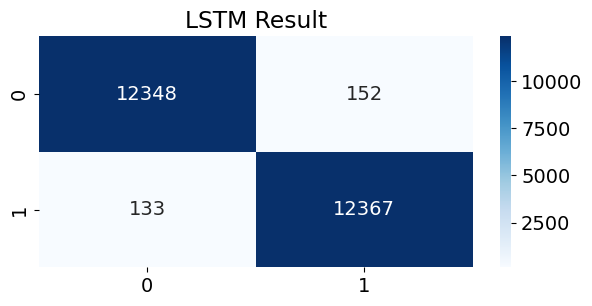

In [10]:
kdf = DataFrame({
    'train': y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')

cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.title('LSTM Result')
plt.show()
plt.close()